# Twitter Sentiment Analysis
## Il caso della guerra russo - ucraina
Data l'odierna centralità che hanno i Social Network nelle nostre vite, la maggior parte delle persone e quindi degli utenti pubblica online il proprio pensiero riguardo la tematica in quel momento in cima alle tendenze. L'idea alla base del progetto è quella di analizzare nel tempo il pensiero comune della popolazione italiana riguardo uno degli eventi storici recenti più impattante: la guerra tra Russia e Ucraina.


L'analisi verrà svolta utilizzando come principale piattaforma Twitter, la cui funzionalità principale riguarda la raccolta di tweet in topic. Verranno scelti diversi hashtag che permetteranno la raccolta dei dati e la creazione di un dataset utile allo scopo finale. Il dataset sarà creato raccogliendo i tweet in fasce temporali diverse e per diversi giorni cosi da spalmare in modo equo i diversi avvenimenti.


Il progetto ha lo scopo di analizzare in modo imparziale il pensiero comune, etichettare i tweet in modo positivo o negativo e fare un'analisi emotiva degli stessi grazie all'uso di più tecniche e librerie. Sarà inoltre utile per capire nel profondo come la popolazione italiana si schiera o pensa in un momento di alta tensione internazionale.

### Autenticazione alle API di Twitter

In [ ]:
import tweepy
import glob
import os

In [ ]:
# Definizione delle chiavi di accesso alle API di Twitter
api_key = "JK6IaHvPpPTpoUKn1uirf8Z5u"
api_key_secret = bearer_token = access_token = access_token_secret = 

# hashtag scelti per la raccolta dei dati
hashtags = ["#putin",
            "#ukraine",
            "#ucraina",
            "#russia",
            "#UkraineWar",
            "#ukrainerussiawar",
            "#UkraineRussiaWar",
            "#ukrainevsrussia",
            "#russiavsukraine",
            "#worldwar3",
            "#PeaceInUkraine",
            "#guerra",
            "#guerraUcraina",
            "#terzaguerramondiale"]


def clean_tweet(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z'àèìòùé?!,&.:;%€()<>=$\" \t])| (\w+:\ / \ / \S+)", " ", text)
                    .split())


# il metodo scorre la lista degli hashtag e per ognuno di essi aggiunge
# l'insieme di tweet raccolti alla lista giornaliera
def create_dataset():
    # set dei token e autenticazione
    auth = tweepy.AppAuthHandler(api_key, api_key_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)
    total_list = []
    for htag in hashtags:
        # raccolta dei tweet in base all'hashtag
        iterator = tweepy.Cursor(api.search_tweets, q=htag, tweet_mode="extended", lang="it").items(500)
        lista = list(iterator)
        # seleziona solo i campi che ci interessano
        output = []

        for tweet in lista:
            text = tweet._json["full_text"]
            retweet_count = tweet.retweet_count
            likes = tweet.favorite_count
            line = {'text': text, 'retweet': retweet_count, 'likes': likes}
            line['text'] = clean_tweet(line.get("text"))
            output.append(line);

        total_list += output;
    return total_list

# lista dei tweet generati
final_list = create_dataset()
# creazione dataset .csv
df = pd.DataFrame(final_list)
df.drop_duplicates(inplace=True, subset=['text'])
df.to_csv('dataset.csv', encoding='utf-8')
df.head(5)

### Unione dei dataset

In [ ]:
#funzione che unisce i 3 diversi dataset in un unico dataset
def data_union():
    files = os.path.join("C:\\Users\\franc\\PycharmProjects\\ProgettoReti\\", "dataset*.csv")
    files = glob.glob(files)
    # unione dei csv
    df = pd.concat(map(pd.read_csv, files), ignore_index=True)
    # aggiunta colonne extra
    df["sentiment"] = 'null'
    df["target"] = 'neutral'
    #salvataggio del nuovo dataset
    df.to_csv("tweet_dataset.csv", encoding='utf-8', index=False)
    return df

df = data_union()
df.drop_duplicates(inplace=True, subset=['text'])
print(len(df.index))

### Labelling del dataset

In [ ]:
import pandas as pd
import seaborn as sns
import csv
import re
from feel_it import EmotionClassifier, SentimentClassifier

In [ ]:
# funzione che utilizza feel_it
# utilizzo di feel_it per l'etichettamento del dataset
def label_dataset():
    sentiment_classifier = SentimentClassifier()
    emotion_classifier = EmotionClassifier()

    # riga per riga vengono aggiornate le nuove colonne
    op = open("tweet_dataset.csv", "r")
    dt = csv.DictReader(op)
    up_dt = []
    count = 0
    for r in dt:
        # modifica della riga
        val_em = emotion_classifier.predict([r['text']])
        val_tar = sentiment_classifier.predict([r['text']])
        row = {'row': count,
                'text': r['text'],
               'retweet': r['retweet'],
               'likes': r['likes'],
               'sentiment': val_em[0],
               'target': val_tar[0]}
        up_dt.append(row)
        count += 1
    op.close()
    op = open("tweet_dataset.csv", "w", newline='')
    headers = ['row','text', 'retweet', 'likes', 'sentiment', 'target']
    data = csv.DictWriter(op, delimiter=',', fieldnames=headers)
    data.writerow(dict((heads, heads) for heads in headers))
    data.writerows(up_dt)
    op.close()
    print('label complete')
    
label_dataset() 

### Topic Modeling

In [1]:
from sentence_transformers import SentenceTransformer
#NB: potrebbe servire avere pyTorch installato.
import umap.umap_ as umap       #necessario per dimensionality reduction
import hdbscan     #necessario per clustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

Batches:   0%|          | 0/184 [00:00<?, ?it/s]

[('gas', 0.13737160443938937), ('rubli', 0.06741674435803695), ('russia', 0.04244810170346292), ('russo', 0.0364861639063066), ('putin', 0.030634568878101058), ('petrolio', 0.030034392866089235), ('europa', 0.027964546262410257), ('rt', 0.026175302557194285), ('pagare', 0.024400122859816093), ('forniture', 0.02431453410442751), ('euro', 0.02411862268111105), ('pagamento', 0.023968739524747165), ('sanzioni', 0.02284886648210016), ('germania', 0.021049495606363735), ('gazprom', 0.019869415257238763)]


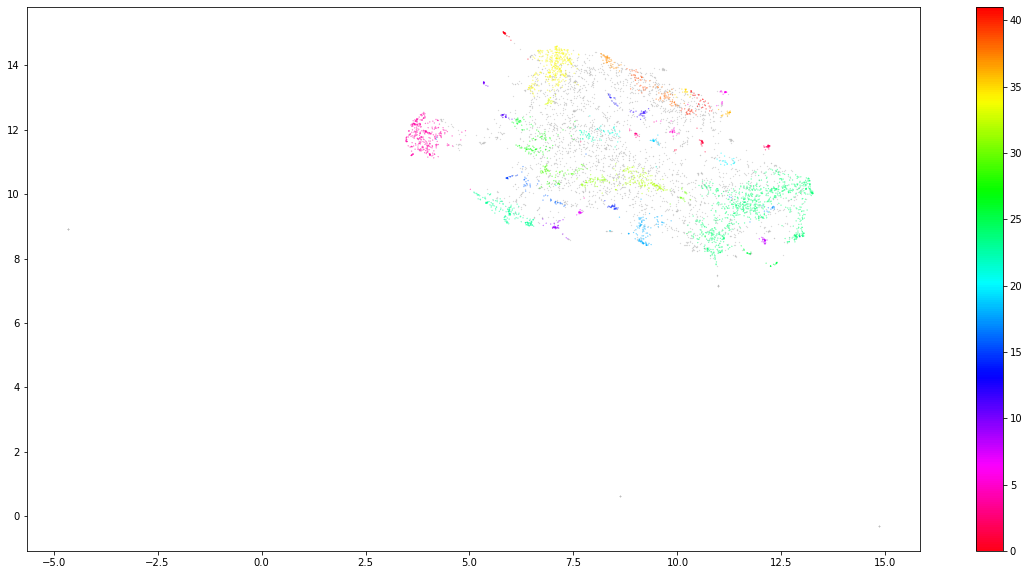

In [2]:
import pandas as pd
from stop_words import get_stop_words
STOP_WORDS =get_stop_words('italian')

filename = 'tweet_dataset.csv'
data_raw = pd.read_csv(filename)

#creo una lista con tutti i testi
data = list(data_raw['text'])

model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
embeddings = model.encode(data, show_progress_bar=True)

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

# DATA VISUALIZATION
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()


# CREAZIONE TOPIC
# creo un nuovo dataframe solo per i topic

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

# raccolta topic
# uniamo i documenti aventi lo stesso topic
docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})


# definiamo la funzione c_tf_idf:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=STOP_WORDS).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


# procediamo
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

In [12]:
# mostra le 15 parole più importanti del topic 4
print(top_n_words[4][:15])

[('gas', 0.13737160443938937), ('rubli', 0.06741674435803695), ('russia', 0.04244810170346292), ('russo', 0.0364861639063066), ('putin', 0.030634568878101058), ('petrolio', 0.030034392866089235), ('europa', 0.027964546262410257), ('rt', 0.026175302557194285), ('pagare', 0.024400122859816093), ('forniture', 0.02431453410442751), ('euro', 0.02411862268111105), ('pagamento', 0.023968739524747165), ('sanzioni', 0.02284886648210016), ('germania', 0.021049495606363735), ('gazprom', 0.019869415257238763)]


In [13]:
#mostra le 15 parole più importanti del topic 3
print(top_n_words[3][:15])

[('mariupol', 0.18124926265827584), ('bombardamento', 0.13882697003999842), ('sentito', 0.1270769067075368), ('attori', 0.11770806359964839), ('recitata', 0.11741149502305719), ('finto', 0.10286882496734456), ('freccero', 0.10154334168171492), ('dire', 0.08372637405336748), ('teatro', 0.0784720423997656), ('piega', 0.07553818230053852), ('parrucchiere', 0.07553818230053852), ('propaganda', 0.07135520395595117), ('servizio', 0.0680699249346542), ('visto', 0.06135769969801625), ('negazionisti', 0.05824979968869694)]


In [14]:
#mostra le 15 parole più importanti del topic 2
print(top_n_words[2][:15])

[('vaccini', 0.14318389047477784), ('vaccino', 0.13961971290651753), ('covid', 0.09221174594819875), ('virus', 0.054475314068501285), ('pandemia', 0.049626680040520045), ('coronavirus', 0.04380923482169961), ('alieni', 0.04380923482169961), ('guerra', 0.043081106115870224), ('san', 0.04207116830793019), ('microchip', 0.03813970156729657), ('giorgio', 0.03813970156729657), ('covid19', 0.033139716379512726), ('draghistan', 0.032561199278027274), ('nogreenpass', 0.03229229745354813), ('invenzione', 0.030768642513534474)]


### Analisi dei risultati

sentiment
anger      3087
fear        645
joy         830
sadness    1308
dtype: int64


<AxesSubplot:>

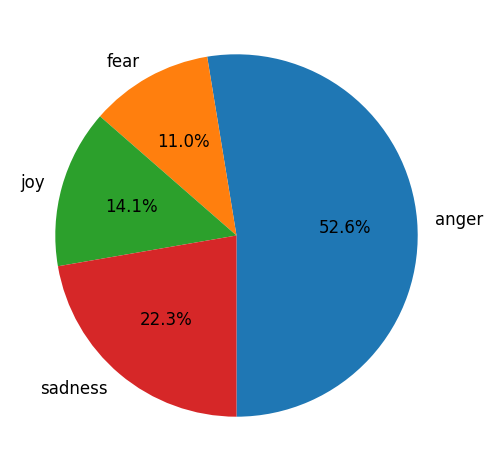

In [5]:
filename = 'tweet_dataset.csv'
df = pd.read_csv(filename)

# plotting percentuali per emozione e target
# per sentimento(gioia, rabbia, paura, tristezza)
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)

# visualizzazione
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

target
negative    5052
positive     818
dtype: int64


<AxesSubplot:>

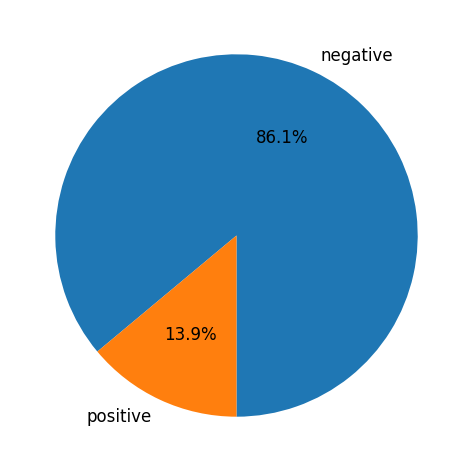

In [6]:
# numero di tweet per target(positivo, negativo, neutrale)
target_counts = df.groupby(['target']).size()
print(target_counts)

# visualizzazione
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
target_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

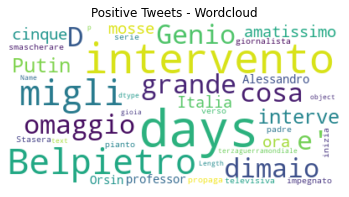

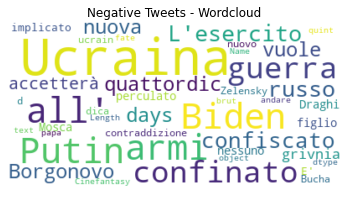

In [9]:
# Wordcloud per i tweet positivi
positive_tweets = df['text'][df["target"] == 'positive']
stop_words = ["https", "co", "RT"] + list(STOP_WORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=120, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 
# Wordcloud per i tweet negativi
negative_tweets = df['text'][df["target"] == 'negative']
stop_words = ["https", "co", "RT"] + list(STOP_WORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=120, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

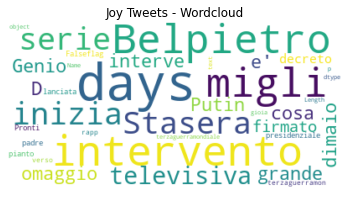

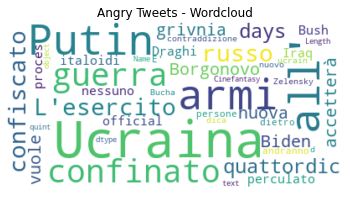

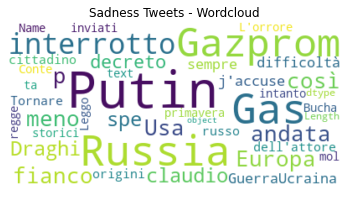

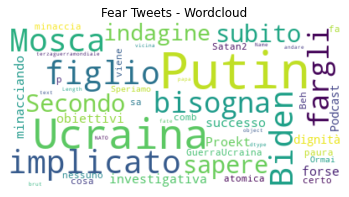

In [10]:
# Wordcloud per i tweet di gioia
negative_tweets = df['text'][df["sentiment"] == 'joy']
stop_words = ["https", "co", "RT"] + list(STOP_WORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=120, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Joy Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud per i tweet di rabbia
negative_tweets = df['text'][df["sentiment"] == 'anger']
stop_words = ["https", "co", "RT"] + list(STOP_WORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=120, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Angry Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud per i tweet di tristezza
negative_tweets = df['text'][df["sentiment"] == 'sadness']
stop_words = ["https", "co", "RT"] + list(STOP_WORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=120, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Sadness Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud per i tweet di paura
negative_tweets = df['text'][df["sentiment"] == 'fear']
stop_words = ["https", "co", "RT"] + list(STOP_WORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=120, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Fear Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()